# 毕业项目：为 Arvato Financial Services 金融服务公司实现一个顾客分类报告

该项目要求你分析德国的一家邮购公司的顾客的人口统计数据，将它和一般的人口统计数据进行比较。你将使用非监督学习技术来实现顾客分类，识别出哪些人群是这家公司的基础核心用户。之后，你将把所学的知识应用到第三个数据集上，该数据集是该公司的一场邮购活动的营销对象的人口统计数据。用你搭建的模型预测哪些人更可能成为该公司的顾客。你要使用的数据由我们的合作伙伴 Bertelsmann Arvato Analytics 公司提供。这是真实场景下的数据科学任务。

如果你完成了这个纳米学位的第一学期，做过其中的非监督学习项目，那么你应该对这个项目的第一部分很熟悉了。两个数据集版本不同。这个项目中用到的数据集会包括更多的特征，而且没有预先清洗过。你也可以自由选取分析数据的方法，而不用按照既定的步骤。如果你选择完成的是这个项目，请仔细记录你的步骤和决策，因为你主要交付的成果就是一篇博客文章报告你的发现。

In [27]:
# import libraries here add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Import sklearn module
from sklearn import cluster
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

In [28]:
workspace_path = {'windows': 'C:\\Data\\avator_data\\', 
                  'mac': '~/GoogleDrive/UdacityDataScience/data/',
                  'udactity': '../../data/Term2/capstone/arvato_data/'}
drive_path = workspace_path['mac']

## 第 0 部分：了解数据

项目数据中包括四个数据文件

- `Udacity_AZDIAS_052018.csv`: 德国的一般人口统计数据；891211 人（行）x 366 个特征（列）
- `Udacity_CUSTOMERS_052018.csv`: 邮购公司顾客的人口统计数据；191652 人（行）x 369 个特征（列）
- `Udacity_MAILOUT_052018_TRAIN.csv`: 营销活动的对象的人口统计数据；42982 人（行）x 367 个特征（列）
- `Udacity_MAILOUT_052018_TEST.csv`: 营销活动的对象的人口统计数据；42833 人（行）x 366个特征（列）

人口统计数据的每一行表示是一个单独的人，也包括一些非个人特征，比如他的家庭信息、住房信息以及周边环境信息。使用前两个数据文件中的信息来发现顾客（"CUSTOMERS"）和一般人（"AZDIAS"）在何种程度上相同和不同，然后根据你的分析对其余两个数据文件（"MAILOUT"）进行预测，预测更可能成为该邮购公司的客户。

"CUSTOMERS" 文件包括三个额外的列（'CUSTOMER_GROUP'、’'ONLINE_PURCHASE' 和 'PRODUCT_GROUP'），提供了文件中顾客的更多维度的信息。原始的 "MAILOUT" 包括一个额外的列 "RESPONSE"，表示每个收到邮件的人是否成为了公司的顾客。对于 "TRAIN" 子数据集，该列被保留，但是在 "TEST" 子数据集中该列被删除了，它和你最后要在 Kaggle 比赛上预测的数据集中保留的列是对应的。

三个数据文件中其他的所有列都是相同的。要获得关于文件中列的更多信息，你可以参考 Workspace 中的两个 Excel 电子表格。[其一](./DIAS Information Levels - Attributes 2017.xlsx) 是一个所有属性和描述的列表，按照信息的类别进行排列。[其二](./DIAS Attributes - Values 2017.xlsx) 是一个详细的每个特征的数据值对应关系，按照字母顺序进行排列。

在下面的单元格中，我们提供了一些简单的代码，用于加载进前两个数据集。注意，这个项目中所有的 `.csv` 数据文件都是分号(`;`) 分割的，所以 [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) 中需要加入额外的参数以正确地读取数据。而且，考虑数据集的大小，加载整个数据集可能会花费一些时间。


你会注意到在数据加载的时候，会弹出一个警告（warning）信息。在你开始建模和分析之前，你需要先清洗一下数据。浏览一下数据集的结构，查看电子表格中信息了解数据的取值。决定一下要挑选哪些特征，要舍弃哪些特征，以及是否有些数据格式需要修订。我们建议创建一个做预处理的函数，因为你需要在使用数据训练模型前清洗所有数据集。

In [29]:
%%time
azdias = pd.read_csv(drive_path + 'Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv(drive_path + 'Udacity_CUSTOMERS_052018.csv', sep=';')

# use column LNR as index
azdias.set_index('LNR', inplace=True)
customers.set_index('LNR', inplace=True)

print('azdias has shape:', azdias.shape, '. customers has shape:', customers.shape)

<string>:2: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.


azdias has shape: (891221, 365) . customers has shape: (191652, 368)
CPU times: user 29.1 s, sys: 5.4 s, total: 34.5 s
Wall time: 34.9 s


In [30]:
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [31]:
customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,NaN,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,0.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


## 第0部分：清洗数据 cleaning Data

在前面的描述中我们知道，customers有三个特征是相对azdias在customers数据中特有的信息。首先，我们把它从customers中分离出来作为customers_special。再清除Customers中的特殊3列。然后让我们看看警告所提出的问题，第17, 18列里到底有什么样的数据问题？

In [32]:
customer_special_columns = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customers

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,NaN,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,0.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154561,1,1.0,9.0,NaN,NaN,NaN,NaN,9.0,1.0,0.0,...,5.0,6.0,9.0,1.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
154563,-1,2.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,...,4.0,NaN,9.0,3.0,3,COSMETIC,SINGLE_BUYER,0,2,4
148813,2,1.0,15.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,5.0,3.0,9.0,3.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4


In [33]:
def remove_customers_special_columns(customers_df):
    ''' split "CUSTOMER_GROUP", "ONLINE_PURCHASE", "PRODUCT_GROUP" in a special dataframe from customers
    Args:
        customers_df {DataFrame} customers data
    Retturns:
    
        {DataFrame} -- with just 3 special columns from the customers
    '''
    # extract special columns from customers
    customers_special_columns = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
    
    return customers_df.drop(customers_special_columns, axis=1, errors='ignore')

In [34]:
customers = remove_customers_special_columns(customers)
print(f'customer columns size is {customers.shape[1]}, azdias columns size is {azdias.shape[1]}')

customer columns size is 365, azdias columns size is 365


In [35]:
azdias[azdias.columns[17]].dtypes

dtype('O')

In [36]:
print('column 18 label is', azdias.columns[17], 'dtype:', azdias[azdias.columns[17]].dtypes, 'and it has values', azdias[azdias.columns[17]].unique()) 
print('column 19 label is', azdias.columns[18], 'dtype:', azdias[azdias.columns[18]].dtypes,'and it has values', azdias[azdias.columns[18]].unique())

column 18 label is CAMEO_DEUG_2015 dtype: object and it has values [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
column 19 label is CAMEO_INTL_2015 dtype: object and it has values [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']


我们发现这两列是ojbect值，我们再查看一下，那些特征由于混合的数据作为Value而是object。我们并且查看一下可以的unique取值。

In [37]:
def display_object_attributs(dataframe):
    '''
    find which column in dataframe has object as dtype. 
    Args:
        dataframe {DataFrame} -- it could be customer or azdias
    Returns:
        {set} -- a set of column names, those the dtypes of column is value type object
    '''
    object_columns = dataframe.loc[:, azdias.dtypes=='object'].columns
    for attr in object_columns:
        attr_unique_values = dataframe[attr].unique()
        print(f'{attr} has value {attr_unique_values}')

In [38]:
print('== display_object_attributs(azdias) ==')
display_object_attributs(azdias)

#print('== find_object_attributs(customers) ==')
#display_object_attributs(customers)

== display_object_attributs(azdias) ==
CAMEO_DEU_2015 has value [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
CAMEO_DEUG_2015 has value [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
CAMEO_INTL_2015 has value [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']
D19_LETZTER_KAUF_BRANCHE has value [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HA

居于上面的方向我们发现了这里有 X 和 XX 的数据，对应于数据描述./DIAS Attributes - Values 2017.xlsx这些并不是有效的值。同时还存在string和number共同存在这些列中。我们将先对这两列作相应的处理。同时我们发现作为需要的值是可以处理为-1，表示unknown。

In [39]:
def cameo_columns_fillna(dataframe):
    '''
    The columns CAMEO_DEU_2015 and CAMEO_INTL_2015 contains string, float as mix value column. There is also XX or X as invalid values,
    we will clean them. 
    Args: 
      dataframe -- {DataFrame} it could be azdias or customers
    Returns:
      None  
    '''
    dataframe['CAMEO_DEU_2015'] = dataframe['CAMEO_DEU_2015'].replace('XX', np.nan).fillna('-1')
    print(f'after cleanup column CAMEO_DEU_2015 has values: {dataframe["CAMEO_DEU_2015"].unique()}\n')

    dataframe['CAMEO_DEUG_2015'] = dataframe['CAMEO_DEUG_2015'].replace('X', np.nan).fillna('-1').astype(int)
    print(f'after cleanup column CAMEO_DEUG_2015 has values: {dataframe["CAMEO_DEUG_2015"].unique()}\n')

    dataframe['CAMEO_INTL_2015'] = dataframe['CAMEO_INTL_2015'].replace('XX', np.nan).fillna('-1').astype(int)
    print(f'after cleanup column CAMEO_INTL_2015 has values: {dataframe["CAMEO_INTL_2015"].unique()}\n')

print('== cameo_columns_fillna in azdias ==')
cameo_columns_fillna(azdias)

print("== cameo_columns_fillna in customers ==")
cameo_columns_fillna(customers)

== cameo_columns_fillna in azdias ==
after cleanup column CAMEO_DEU_2015 has values: ['-1' '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A'
 '5D' '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C'
 '7C' '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B'
 '6F' '5F' '1C']

after cleanup column CAMEO_DEUG_2015 has values: [-1  8  4  2  6  1  9  5  7  3]

after cleanup column CAMEO_INTL_2015 has values: [-1 51 24 12 43 54 22 14 13 15 33 41 34 55 25 23 31 52 35 45 44 32]

== cameo_columns_fillna in customers ==
after cleanup column CAMEO_DEU_2015 has values: ['1A' '-1' '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C'
 '9C' '4E' '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C'
 '7C' '5A' '2B' '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D'
 '7D' '6F' '4D']

after cleanup column CAMEO_DEUG_2015 has values: [ 1 -1  5  4  7  3  9  2  6  8]

after cleanup column CAMEO_INTL_2015 has values: [13 -1 34 24 41 23 15 55 14 22 43 

In [40]:
display_object_attributs(azdias)

CAMEO_DEU_2015 has value ['-1' '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A'
 '5D' '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C'
 '7C' '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B'
 '6F' '5F' '1C']
D19_LETZTER_KAUF_BRANCHE has value [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE' 'D19_REISEN' 'D19_BEKLEIDUNG_GEH'
 'D19_TECHNIK' 'D19_NAHRUNGSERGAENZUNG' 'D19_DIGIT_SERV' 'D19_LOTTO'
 'D19_RATGEBER' 'D19_TIERARTIKEL' 'D19_KINDERARTIKEL' 'D19_BIO_OEKO'
 'D19_WEIN_FEINKOST' 'D19_GARTEN' 'D19_BILDUNG' 'D19_BANKEN_LOKAL']
EINGEFUEGT_AM has value [nan '1992-02-10 00:00:00' '1992-02-12 00:00:00' ... '2010-12-02 00

列CAMEO_DEU_2015和OST_WEST_KZ是分类值，这里我们对其进行one hot编码。

In [41]:
pd.get_dummies(data=customers[['OST_WEST_KZ', 'CAMEO_DEU_2015']].replace('-1', np.nan), prefix_sep='__')

,OST_WEST_KZ__O,OST_WEST_KZ__W,CAMEO_DEU_2015__1A,CAMEO_DEU_2015__1B,CAMEO_DEU_2015__1C,CAMEO_DEU_2015__1D,CAMEO_DEU_2015__1E,CAMEO_DEU_2015__2A,CAMEO_DEU_2015__2B,CAMEO_DEU_2015__2C,...,CAMEO_DEU_2015__7E,CAMEO_DEU_2015__8A,CAMEO_DEU_2015__8B,CAMEO_DEU_2015__8C,CAMEO_DEU_2015__8D,CAMEO_DEU_2015__9A,CAMEO_DEU_2015__9B,CAMEO_DEU_2015__9C,CAMEO_DEU_2015__9D,CAMEO_DEU_2015__9E
LNR,,,,,,,,,,,,,,,,,,,,,
9626,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143872,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143873,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143874,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154561,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154563,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
148813,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
def one_hot_encode_categorie_columns(dataframe, categorie_columns = ['CAMEO_DEU_2015', 'OST_WEST_KZ']):
    '''
    one hot encode categorical columns, the nan will be ignored
    Args: 
        dataframe {DataFrame} -- customes or azdias
        categorie_columns {list} -- column names, default value ['CAMEO_DEU_2015', 'OST_WEST_KZ']
    Returns:
        dataframe of selected columns in one hot encoding 
    '''

    return pd.get_dummies(data=dataframe[categorie_columns].replace('-1', np.nan), prefix_sep='__')


In [43]:
customers_categorigcal_df = one_hot_encode_categorie_columns(customers)
azdias_categorigcal_df = one_hot_encode_categorie_columns(azdias)

我们在这里定义两个dataframes customers_unprocessed_df 和 azdias_unprocessed_df用于每次处理完后的数据。

In [44]:
processed_attributes = ['CAMEO_DEU_2015', 'OST_WEST_KZ']
customers_unprocessed_df = customers.drop(processed_attributes, axis=1, errors='ignore')
azdias_unprocessed_df = azdias.drop(processed_attributes, axis=1, errors='ignore')

In [45]:
processed_attributes

['CAMEO_DEU_2015', 'OST_WEST_KZ']

### 空值处理

Arvato 提供了对应的Meta数据集，Attributes是所有像个的描述。Values包含了每个Attribute可能的数据值，以及其对应的意义Meaning。这里我们把他读取出来，整理成一些相应需要的变量，为后面的数据清洗做准备。特别是Unknown数据，我们可以利用描述来找到对应的值，准备好清洗掉它们。

In [46]:
# load from xlsx files
attribute_info_df = pd.read_excel(drive_path + 'DIAS Information Levels - Attributes 2017.xlsx', index_col=None, header=1)
attribute_values_df = pd.read_excel(drive_path + 'DIAS Attributes - Values 2017.xlsx', index_col=None, header=1)

# delte empty cell
del attribute_info_df['Unnamed: 0']
del attribute_values_df['Unnamed: 0']

attribute_values_df = attribute_values_df.fillna(method='ffill', axis=0) # fill merged-cell with first value in above
print('attribute_info_df has shape:', attribute_info_df.shape, '. attribute_values_df has shape', attribute_values_df.shape)

attribute_info_df has shape: (313, 4) . attribute_values_df has shape (2258, 4)


In [47]:
def load_xlsx_files():
    ''' load data from DIAS Information Levels - Attributes 2017.xlsx and DIAS Attributes - Values 2017.xlsx
    Returns: 
        attribute_info_df {DataFrame} data from "DIAS Information Levels - Attributes 2017.xlsx"
        attribute_values_df {DataFrame} data from "DIAS Attributes - Values 2017.xlsx"
    '''
    # load from xlsx files
    attribute_info_df = pd.read_excel(drive_path + 'DIAS Information Levels - Attributes 2017.xlsx', index_col=None, header=1)
    attribute_values_df = pd.read_excel(drive_path + 'DIAS Attributes - Values 2017.xlsx', index_col=None, header=1)

    # delte empty cell
    del attribute_info_df['Unnamed: 0']
    del attribute_values_df['Unnamed: 0']

    attribute_values_df = attribute_values_df.fillna(method='ffill', axis=0) # fill merged-cell with first value in above
    return attribute_info_df, attribute_values_df

In [48]:
attribute_info_df, attribute_values_df = load_xlsx_files()

In [49]:
attribute_info_df.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [50]:
attribute_values_df.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


在DIAS Attirbutes - Values 2017.xlsx中，我们发现下面的7列是连续的数值型。它们没有默认的值用于填充nan。这些列我们采用了中值填补的方式填充nan。我们利用Sklearn中的`SimpleImputer(strategy='median')`

In [51]:
numeric_attributes = attribute_values_df[attribute_values_df['Value'] == '…']
numeric_attributes

,Attribute,Description,Value,Meaning
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
37,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10)
38,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3)
39,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10)
711,GEBURTSJAHR,year of birth,…,numeric value
1167,KBA13_ANZAHL_PKW,number of cars in the PLZ8,…,numeric value
1986,MIN_GEBAEUDEJAHR,year the building was first mentioned in our d...,…,numeric value


In [52]:
def numeric_fillna_median(dataframe, numeric_attributes):

    std_numeric_columns = pd.DataFrame(index = dataframe.index)

    for col_name in numeric_attributes['Attribute']:
        # scaler = StandardScaler()
        # data = dataframe.loc[:, col_name].values.reshape(-1, 1)
        # std_numeric_columns[col_name] = scaler.fit_transform(data)
        # print(col_name, 'will be standarized， std：', std_numeric_columns[col_name].std(), 'and mean:', std_numeric_columns[col_name].mean())

        imp_meduan = SimpleImputer(strategy='median')
        data = dataframe.loc[:, col_name].values.reshape(-1, 1)
        # data = std_numeric_columns[col_name].values.reshape(-1, 1)
        std_numeric_columns[col_name] = imp_meduan.fit_transform(data)
        
    return std_numeric_columns

print('================= fillna with meidan of numeric attributes in customers ==================')
customers_numeric_df = numeric_fillna_median(customers, numeric_attributes)
print('================= fillna with meidan of numeric attributes in azdias ==================')
azdias_numeric_df = numeric_fillna_median(azdias, numeric_attributes)

================= fillna with meidan of numeric attributes in customers ==================
================= fillna with meidan of numeric attributes in azdias ==================


In [53]:
customers_numeric_df.head(20)

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
LNR,,,,,,,
9626,1.0,0.0,2.0,0.0,0.0,1201.0,1992.0
9628,1.0,0.0,3.0,0.0,0.0,593.0,1992.0
143872,1.0,0.0,1.0,0.0,0.0,433.0,1992.0
143873,0.0,0.0,0.0,0.0,0.0,755.0,1992.0
143874,7.0,0.0,4.0,0.0,1960.0,513.0,1992.0
143888,1.0,0.0,2.0,0.0,0.0,1167.0,1992.0
143904,1.0,0.0,2.0,0.0,1942.0,1300.0,1992.0
143910,1.0,0.0,2.0,0.0,1938.0,481.0,1992.0
102160,74.0,2.0,1.0,0.0,1914.0,428.0,1994.0


In [54]:
processed_attributes = processed_attributes + list(customers_numeric_df.columns)
print( processed_attributes )

['CAMEO_DEU_2015', 'OST_WEST_KZ', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']


In [55]:
list(customers_numeric_df.columns)

['ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR']

In [56]:
customers_unprocessed_df = customers.drop(processed_attributes, axis=1, errors='ignore')
azdias_unprocessed_df = azdias.drop(processed_attributes, axis=1, errors='ignore')

In [57]:
customers_numeric_df.info()
azdias_numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 9626 to 148883
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ANZ_HAUSHALTE_AKTIV  191652 non-null  float64
 1   ANZ_HH_TITEL         191652 non-null  float64
 2   ANZ_PERSONEN         191652 non-null  float64
 3   ANZ_TITEL            191652 non-null  float64
 4   GEBURTSJAHR          191652 non-null  float64
 5   KBA13_ANZAHL_PKW     191652 non-null  float64
 6   MIN_GEBAEUDEJAHR     191652 non-null  float64
dtypes: float64(7)
memory usage: 11.7 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 910215 to 825787
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ANZ_HAUSHALTE_AKTIV  891221 non-null  float64
 1   ANZ_HH_TITEL         891221 non-null  float64
 2   ANZ_PERSONEN         891221 non-null  float64
 3   ANZ_TITEL   

其他绝大部分的列收有对应的unknown值，我们可以用这些值来作为填充nan的值。有些特征还是有两个值拥有同样的unkown意义。所以我们在这里只选用第一个只来填充nan，并且把第二个可能的值（比如0，或者9）也用第一个默认值加以替换。这些处理后的列我们已将其单独放入customers_processed_columns和azdias_processed_columns的dataFrame中。在反复的清理数据的过程中，我们还发先了几条和unknown类似的数据值，Inactive， none，no Online-transactions within the last 12 months。

In [58]:
# display all possilbe meaning has substring 'known' 
meaning_se = pd.Series(attribute_values_df['Meaning'].unique())
meaning_se[meaning_se.str.contains('known', flags=re.IGNORECASE, regex=True)]

0                                                unknown
10                      unknown / no main age detectable
129                                no transactions known
145                                 no transaction known
199    residental building buildings without actually...
201    mixed building without actually known househol...
202                  company building w/o known company 
203     mixed building without actually known household 
205       mixed building without actually known company 
dtype: object

In [59]:
def get_unknown_values(attribute_values_df):
    ''' 
    We want to get all allowed values of attributes, which could have "unknown" meaning values. 
    
    Args: attribute_values_df -- {DataFrame} from "DIAS Attributes - Values 2017.xlsx"
    '''
    unknown_meanings = ['unknown', 
                        'unknown / no main age detectable',
                        'no transactions known',
                        'no transaction known',
                        'no Online-transactions within the last 12 months',
                        'Inactive', 
                        'none']
    attribute_unknown_values = attribute_values_df[attribute_values_df['Meaning'].isin(unknown_meanings)][['Attribute','Value']]
    return attribute_unknown_values

column_unknow_values = get_unknown_values(attribute_values_df)
column_unknow_values

,Attribute,Value
0,AGER_TYP,-1
5,ALTERSKATEGORIE_GROB,"-1, 0"
11,ALTER_HH,0
33,ANREDE_KZ,"-1, 0"
40,BALLRAUM,-1
...,...,...
2219,WOHNDAUER_2008,"-1, 0"
2229,WOHNLAGE,-1
2238,WACHSTUMSGEBIET_NB,"-1, 0"
2244,W_KEIT_KIND_HH,"-1, 0"


In [60]:
def get_columns_has_nan(dataframe):
    return dataframe.columns[dataframe.isna().any()].tolist()

In [61]:
def process_unknown_and_nan(dataframe, column_unknow_values, processed_attributes, show_details = False):
    '''
    dataframe has columns, which hast possilbe value with meaning like "unknown", we use this value fill nan. 
    If the "Unknown" has 2 possible values, we just us the first one. 
    Arges:
        dataframe {DataFrame} -- customers or azidas
        column_unknow_values {dataFrame} -- part of from data frome DIAS=Attributes - Values 2017.xlsx, which has selected meaning like 'unknown'
    '''
    dataframe = dataframe.drop(processed_attributes, axis=1)
    processed_df = pd.DataFrame(index=dataframe.index)
    not_found_attrs = set()
    for idx, row in column_unknow_values.iterrows():
        # there some columns name different
        attr_name = row['Attribute'].replace('_RZ', '')
        attr_default_values = list( map ( int, str(row['Value']).split(',') ))

        if attr_name not in dataframe.columns:
            not_found_attrs.add(attr_name)
        else:
            col = dataframe[attr_name]
            col = col.fillna(attr_default_values[0])
            if len(attr_default_values) == 2:
                col = col.replace(attr_default_values[1], attr_default_values[0])
                if show_details:
                    print( attr_name, 'fill', attr_default_values[1], 'and NaN with', attr_default_values[0])
            else:
                if show_details:
                    print( attr_name, 'fill nan with', attr_default_values[0])
            processed_df[attr_name] = col
    
    if show_details:
        print('the following attributes can not be found:', not_found_attrs)
        
    return processed_df

In [62]:
customers_unknown_filled_df = process_unknown_and_nan(customers, column_unknow_values, processed_attributes, True)
customers_unknown_filled_df

AGER_TYP fill nan with -1
ALTERSKATEGORIE_GROB fill 0 and NaN with -1
ALTER_HH fill nan with 0
ANREDE_KZ fill 0 and NaN with -1
BALLRAUM fill nan with -1
CAMEO_DEUG_2015 fill nan with -1
CJT_GESAMTTYP fill nan with 0
D19_BANKEN_ANZ_12 fill nan with 0
D19_BANKEN_ANZ_24 fill nan with 0
D19_BANKEN_DATUM fill nan with 10
D19_BANKEN_DIREKT fill nan with 0
D19_BANKEN_GROSS fill nan with 0
D19_BANKEN_LOKAL fill nan with 0
D19_BANKEN_OFFLINE_DATUM fill nan with 10
D19_BANKEN_ONLINE_DATUM fill nan with 10
D19_BANKEN_ONLINE_QUOTE_12 fill nan with 0
D19_BANKEN_REST fill nan with 0
D19_BEKLEIDUNG_GEH fill nan with 0
D19_BEKLEIDUNG_REST fill nan with 0
D19_BILDUNG fill nan with 0
D19_BIO_OEKO fill nan with 0
D19_DIGIT_SERV fill nan with 0
D19_DROGERIEARTIKEL fill nan with 0
D19_ENERGIE fill nan with 0
D19_FREIZEIT fill nan with 0
D19_GARTEN fill nan with 0
D19_GESAMT_ANZ_12 fill nan with 0
D19_GESAMT_ANZ_24 fill nan with 0
D19_GESAMT_DATUM fill nan with 10
D19_GESAMT_OFFLINE_DATUM fill nan with 10


,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2,4,10.0,1,3.0,1,5.0,0,0,10,...,6,1,6,3,-1.0,1,9.0,7.0,6.0,3
9628,-1,4,11.0,1,-1.0,-1,0.0,0,1,6,...,3,1,7,3,-1.0,1,9.0,-1.0,-1.0,3
143872,-1,4,6.0,2,7.0,5,2.0,0,0,10,...,2,1,3,1,-1.0,2,9.0,2.0,6.0,3
143873,1,4,8.0,1,7.0,4,2.0,0,0,10,...,6,4,7,0,-1.0,1,9.0,7.0,-1.0,1
143874,-1,3,20.0,1,3.0,7,6.0,1,2,3,...,4,4,5,1,-1.0,2,9.0,3.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154561,1,3,9.0,1,1.0,1,4.0,0,1,7,...,6,4,7,1,-1.0,2,9.0,1.0,6.0,3
154563,-1,4,0.0,2,6.0,5,2.0,0,0,10,...,2,3,2,3,-1.0,2,9.0,3.0,-1.0,3
148813,2,4,15.0,1,7.0,4,2.0,0,0,10,...,4,1,6,0,-1.0,1,9.0,3.0,3.0,3


查看一下还有那些列里有nan值。

In [63]:
azdias_unknown_filled_df = process_unknown_and_nan(azdias, column_unknow_values, processed_attributes, True)
azdias_unknown_filled_df

AGER_TYP fill nan with -1
ALTERSKATEGORIE_GROB fill 0 and NaN with -1
ALTER_HH fill nan with 0
ANREDE_KZ fill 0 and NaN with -1
BALLRAUM fill nan with -1
CAMEO_DEUG_2015 fill nan with -1
CJT_GESAMTTYP fill nan with 0
D19_BANKEN_ANZ_12 fill nan with 0
D19_BANKEN_ANZ_24 fill nan with 0
D19_BANKEN_DATUM fill nan with 10
D19_BANKEN_DIREKT fill nan with 0
D19_BANKEN_GROSS fill nan with 0
D19_BANKEN_LOKAL fill nan with 0
D19_BANKEN_OFFLINE_DATUM fill nan with 10
D19_BANKEN_ONLINE_DATUM fill nan with 10
D19_BANKEN_ONLINE_QUOTE_12 fill nan with 0
D19_BANKEN_REST fill nan with 0
D19_BEKLEIDUNG_GEH fill nan with 0
D19_BEKLEIDUNG_REST fill nan with 0
D19_BILDUNG fill nan with 0
D19_BIO_OEKO fill nan with 0
D19_DIGIT_SERV fill nan with 0
D19_DROGERIEARTIKEL fill nan with 0
D19_ENERGIE fill nan with 0
D19_FREIZEIT fill nan with 0
D19_GARTEN fill nan with 0
D19_GESAMT_ANZ_12 fill nan with 0
D19_GESAMT_ANZ_24 fill nan with 0
D19_GESAMT_DATUM fill nan with 10
D19_GESAMT_OFFLINE_DATUM fill nan with 10


,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
LNR,,,,,,,,,,,,,,,,,,,,,
910215,-1,2,0.0,1,-1.0,-1,2.0,0,0,10,...,2,3,1,-1,-1.0,-1,-1.0,-1.0,-1.0,3
910220,-1,1,0.0,2,6.0,8,5.0,0,0,10,...,5,6,1,3,-1.0,2,9.0,4.0,3.0,5
910225,-1,3,17.0,2,2.0,4,3.0,0,0,10,...,4,3,4,2,-1.0,1,9.0,2.0,3.0,5
910226,2,4,13.0,2,4.0,2,2.0,0,0,10,...,5,4,4,1,-1.0,1,9.0,7.0,-1.0,3
910241,-1,3,20.0,1,2.0,6,5.0,3,5,5,...,6,2,7,2,-1.0,2,9.0,3.0,2.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825761,-1,3,17.0,2,6.0,7,5.0,0,0,10,...,2,2,2,3,-1.0,1,4.0,3.0,3.0,4
825771,-1,2,16.0,1,7.0,9,4.0,0,0,10,...,4,2,4,-1,-1.0,-1,9.0,5.0,6.0,6
825772,-1,2,17.0,2,5.0,4,4.0,0,0,9,...,5,7,2,2,-1.0,1,5.0,7.0,-1.0,4


In [64]:
processed_attributes = processed_attributes + list(customers_unknown_filled_df.columns)
print(processed_attributes)

['CAMEO_DEU_2015', 'OST_WEST_KZ', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR', 'AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ANREDE_KZ', 'BALLRAUM', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', '

In [65]:
customers_unprocessed_df = customers.drop(processed_attributes, axis=1, errors='ignore')
azdias_unprocessed_df = azdias.drop(processed_attributes, axis=1, errors='ignore')

In [66]:
customers_unprocessed_df.info()
azdias_unprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 9626 to 148883
Data columns (total 71 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AKT_DAT_KL                  145056 non-null  float64
 1   ALTER_KIND1                 11766 non-null   float64
 2   ALTER_KIND2                 5100 non-null    float64
 3   ALTER_KIND3                 1275 non-null    float64
 4   ALTER_KIND4                 236 non-null     float64
 5   ALTERSKATEGORIE_FEIN        139810 non-null  float64
 6   ANZ_KINDER                  145056 non-null  float64
 7   ANZ_STATISTISCHE_HAUSHALTE  141725 non-null  float64
 8   ARBEIT                      141176 non-null  float64
 9   CAMEO_INTL_2015             191652 non-null  int64  
 10  CJT_KATALOGNUTZER           188439 non-null  float64
 11  CJT_TYP_1                   188439 non-null  float64
 12  CJT_TYP_2                   188439 non-null  float64
 13  CJT_TYP_3  

In [67]:
print(get_columns_has_nan(customers))

['AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'ARBEIT', 'BALLRAUM', 'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'EWDICHTE', 'EXTSEL992', 'FIRMENDICHTE', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GEMEINDETYP', 'GFK_URLAUBERTYP', 'HH_DELTA_FLAG', 'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1', 'KBA05_CCM

为什么还有这些列没有被默认值填补空值呢？我们再利用两个DIAS提供的meta数据开对比我们的customers和azdias的列，看看是不是还有一些偏差。

In [68]:
azdias_attributes = azdias.columns
customer_attributes = customers.columns
attributes_in_valuesDf = attribute_values_df['Attribute'].unique()
attributes_in_attributesDf = attribute_info_df['Attribute'].unique()

print(f'there are {azdias_attributes.size} in azdias')
print(f'there are {customer_attributes.size} in customers')
print(f'there are {attributes_in_valuesDf.shape[0]} in attribute_values_df')
print(f'there are {attributes_in_attributesDf.shape[0]} in attribute_info_df')

there are 365 in azdias
there are 365 in customers
there are 314 in attribute_values_df
there are 313 in attribute_info_df


In [69]:
def get_attribute_without_value_info():
    attributes_without_meta = set()
    ind = 0
    for attr in azdias_attributes:
        ind += 1
        if attr not in attributes_in_valuesDf and attr+'_RZ' not in attributes_in_attributesDf:
            attributes_without_meta.add(attr)
    return attributes_without_meta

def show_attribute_without_value_info_details():
    ind = 0
    print('===== Flowing Columns are not in "DIAS Attributes - Values 2017.xlsx" =====')
    for attr in azdias_attributes:
        ind += 1
        if attr not in attributes_in_valuesDf and attr+'_RZ' not in attributes_in_attributesDf:
            azdias_attr_unique = azdias[attr].sort_values().unique()
            customers_attr_unique = customers[attr].sort_values().unique()
            print(f'Column No.{ind} {attr} in azdias has {len(azdias_attr_unique)}\nvalues in azdias are: {azdias_attr_unique}\nvalues in customers are: {customers_attr_unique}')

attributes_without_meta = get_attribute_without_value_info()
show_attribute_without_value_info_details()

===== Flowing Columns are not in "DIAS Attributes - Values 2017.xlsx" =====
Column No.2 AKT_DAT_KL in azdias has 10
values in azdias are: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. nan]
values in customers are: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. nan]
Column No.4 ALTER_KIND1 in azdias has 18
values in azdias are: [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. nan]
values in customers are: [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. nan]
Column No.5 ALTER_KIND2 in azdias has 18
values in azdias are: [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. nan]
values in customers are: [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. nan]
Column No.6 ALTER_KIND3 in azdias has 16
values in azdias are: [ 4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. nan]
values in customers are: [ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. nan]
Column No.7 ALTER_KIND4 in azdias has 13
values in azdias are: [ 

In [70]:
print(f'===== Flowing {len(attributes_without_meta)} Columns are not in "DIAS Attributes - Values 2017.xlsx" =====\n', attributes_without_meta)

===== Flowing 61 Columns are not in "DIAS Attributes - Values 2017.xlsx" =====
 {'CAMEO_INTL_2015', 'ALTERSKATEGORIE_FEIN', 'EINGEZOGENAM_HH_JAHR', 'CJT_KATALOGNUTZER', 'CJT_TYP_4', 'D19_LOTTO', 'ALTER_KIND1', 'CJT_TYP_2', 'CJT_TYP_3', 'D19_VERSI_OFFLINE_DATUM', 'VHN', 'UMFELD_ALT', 'ANZ_KINDER', 'KBA13_CCM_1401_2500', 'AKT_DAT_KL', 'CJT_TYP_5', 'CJT_TYP_6', 'KOMBIALTER', 'ALTER_KIND3', 'ANZ_STATISTISCHE_HAUSHALTE', 'KBA13_ANTG4', 'VK_DISTANZ', 'HH_DELTA_FLAG', 'KBA13_HHZ', 'CJT_TYP_1', 'D19_BUCH_CD', 'KBA13_ANTG1', 'KK_KUNDENTYP', 'RT_SCHNAEPPCHEN', 'DSL_FLAG', 'KBA13_KMH_210', 'VK_DHT4A', 'D19_KONSUMTYP_MAX', 'VK_ZG11', 'KBA13_ANTG2', 'ARBEIT', 'UNGLEICHENN_FLAG', 'ALTER_KIND2', 'EXTSEL992', 'GEMEINDETYP', 'D19_TELKO_ONLINE_QUOTE_12', 'FIRMENDICHTE', 'KONSUMZELLE', 'RT_UEBERGROESSE', 'D19_VERSI_ONLINE_DATUM', 'KBA13_ANTG3', 'MOBI_RASTER', 'KBA13_BAUMAX', 'UMFELD_JUNG', 'D19_LETZTER_KAUF_BRANCHE', 'STRUKTURTYP', 'D19_SOZIALES', 'D19_VERSI_DATUM', 'RT_KEIN_ANREIZ', 'VERDICHTUNGSRAUM', 

通过上面的数字，的确我们发现在azdias和customer的特征列数量和描述数据values和attributs不对应。这里我们进一步通过显示数据来做分析。

通过观察我们发现，D19_LETZTER_KAUF_BRANCHE的值刚好对应了其他D19的列，数据看上去有一定的重复。CJT_KATALOGNUTZER也是类似情况，被其他CJT列所重复。ANZ_STATISTISCHE_HAUSHALTE，EXTSEL992有大量的数值，但是我们这里缺乏具体的meta数据，这里我们决定不再保留。EINGEZOGENAM_HH_JAHR。GEBURTSJAHR是出身年份，我们还有其他的列含有相关年龄的列ALTER_HH所以我们也决定忽略。对比azdias和DIAS Information Levels和DIAS Attibutes - Values 2017.xlsx中的Attribute，特征定义和值描述之间有差异。ARBEIT是德语的工作，但是我们没有有关具体值的描述。CAMEO_DEUINTL_2015应该是对应CAMEO_INTL_2015。

In [71]:
print('processed_attributes has', len(processed_attributes))
print('attributes_without_meta', len(attributes_without_meta))
processed_attributes = processed_attributes + list(attributes_without_meta)
print('put together into processed_attributes, it has', len(processed_attributes))


processed_attributes has 294
attributes_without_meta 61
put together into processed_attributes, it has 355


In [72]:
customers_unprocessed_df = customers.drop(processed_attributes, axis=1, errors='ignore')
azdias_unprocessed_df = azdias.drop(processed_attributes, axis=1, errors='ignore')
azdias_unprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 910215 to 825787
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   GEBAEUDETYP_RASTER   798066 non-null  float64
 1   GFK_URLAUBERTYP      886367 non-null  float64
 2   GREEN_AVANTGARDE     891221 non-null  int64  
 3   KONSUMNAEHE          817252 non-null  float64
 4   LP_FAMILIE_FEIN      886367 non-null  float64
 5   LP_FAMILIE_GROB      886367 non-null  float64
 6   LP_LEBENSPHASE_FEIN  886367 non-null  float64
 7   LP_LEBENSPHASE_GROB  886367 non-null  float64
 8   LP_STATUS_FEIN       886367 non-null  float64
 9   LP_STATUS_GROB       886367 non-null  float64
 10  PLZ8_BAUMAX          774706 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 81.6 MB


In [73]:
def drop_no_info_columns(dataframe, attributes_without_meta):
    column_count_before = dataframe.shape[1]
    columns_to_drop = attributes_without_meta
    result = dataframe.drop(columns=columns_to_drop, axis=1, errors='ignore')
    print(f'before drop columns count:{column_count_before}, and after drop columns count:{result.shape[1]}')
    return result

In [74]:
customers_unprocessed_df.info()
azdias_unprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 9626 to 148883
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   GEBAEUDETYP_RASTER   141725 non-null  float64
 1   GFK_URLAUBERTYP      188439 non-null  float64
 2   GREEN_AVANTGARDE     191652 non-null  int64  
 3   KONSUMNAEHE          145001 non-null  float64
 4   LP_FAMILIE_FEIN      188439 non-null  float64
 5   LP_FAMILIE_GROB      188439 non-null  float64
 6   LP_LEBENSPHASE_FEIN  188439 non-null  float64
 7   LP_LEBENSPHASE_GROB  188439 non-null  float64
 8   LP_STATUS_FEIN       188439 non-null  float64
 9   LP_STATUS_GROB       188439 non-null  float64
 10  PLZ8_BAUMAX          138888 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 17.5 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 910215 to 825787
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
--- 

In [75]:
azdias = drop_no_info_columns(azdias, attributes_without_meta)
customers = drop_no_info_columns(customers, attributes_without_meta)

before drop columns count:365, and after drop columns count:304
before drop columns count:365, and after drop columns count:304


In [76]:
# check again nan columns
get_columns_has_nan(customers_unprocessed_df)

['GEBAEUDETYP_RASTER',
 'GFK_URLAUBERTYP',
 'KONSUMNAEHE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'PLZ8_BAUMAX']

#### 在FEIN和GROB数据中做选择

在属性描述中我们看到，有不少属性我们同时拥有细化（FEIN）和粗略（GROB）的数据特征。这里在试验初期我们决定采用细化（FEIN）的特征。而且通过图形我们也可以看到，在数据上有完全一样的分布。

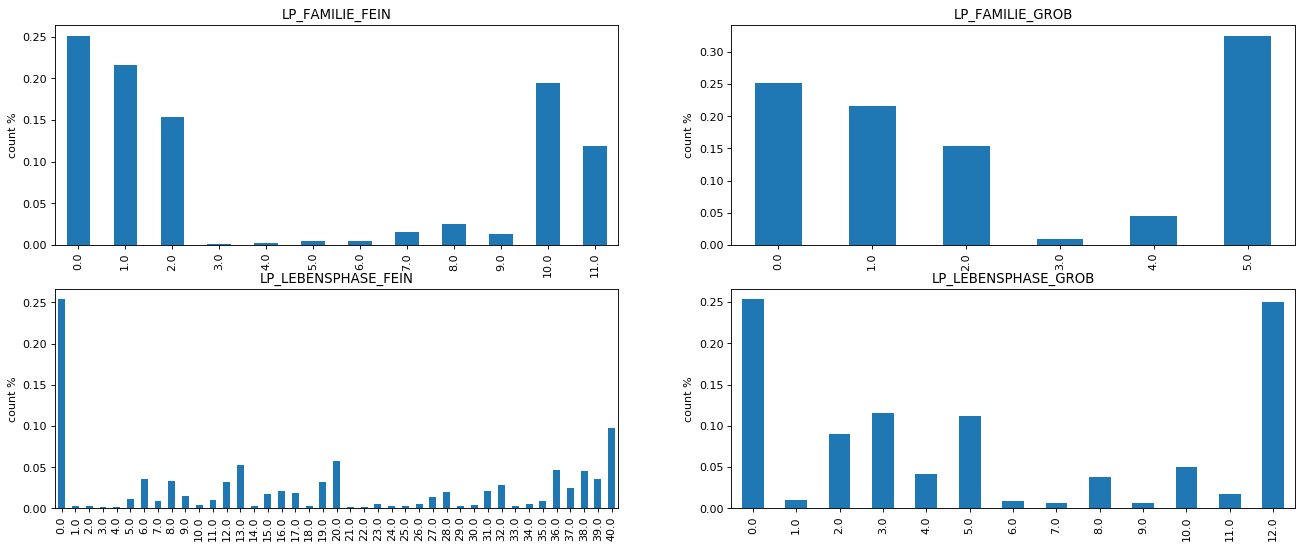

In [131]:
fig=plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2, 2, 1)
customers['LP_FAMILIE_FEIN'].value_counts(normalize=True).sort_index().plot.bar(title='LP_FAMILIE_FEIN').set_ylabel("count %")
plt.subplot(2, 2, 2)
customers['LP_FAMILIE_GROB'].value_counts(normalize=True).sort_index().plot.bar(title='LP_FAMILIE_GROB').set_ylabel("count %")

plt.subplot(2, 2, 3)
customers['LP_LEBENSPHASE_FEIN'].value_counts(normalize=True).sort_index().plot.bar(title='LP_LEBENSPHASE_FEIN').set_ylabel("count %")
plt.subplot(2, 2, 4)
customers['LP_LEBENSPHASE_GROB'].value_counts(normalize=True).sort_index().plot.bar(title='LP_LEBENSPHASE_GROB').set_ylabel("count %")

plt.show()

In [78]:
def get_columns_endswith_grob(dataframe):
    '''
    find a list of attributes, which name has ending "_GROB".
    Args:
        dataframe {DataFrame} -- azdias or customers
    '''
    grob_columns = []
    for attr in dataframe.columns:
        if attr.endswith('_GROB'):
            grob_columns.append(attr)
    return grob_columns

def drop_grob_columns(dataframe):
    columns_to_drop = []
    for attr in dataframe.columns:
        if attr.endswith('_GROB'):
            columns_to_drop.append(attr)
    print(f'delete {columns_to_drop} from dataframe')
    dataframe.drop(columns=columns_to_drop, axis=1, errors='ignore', inplace=True)

In [79]:
print('========= delete _GROBs from unprocessed azdias ==========')
drop_grob_columns(azdias_unprocessed_df)

print('========= delete _GROBs from unprocessed customers ========')
drop_grob_columns(customers_unprocessed_df)

========= delete _GROBs from unprocessed azdias ==========
delete ['LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB'] from dataframe
========= delete _GROBs from unprocessed customers ========
delete ['LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB'] from dataframe


In [80]:
print('processed_attributes has', len(set(processed_attributes)))
grob_columns = get_columns_endswith_grob(customers)
print(len(grob_columns), 'columns ends with "_GROB"')

processed_attributes = processed_attributes + grob_columns

print('put together into processed_attributes, it has', len(set(processed_attributes)))

processed_attributes has 354
4 columns ends with "_GROB"
put together into processed_attributes, it has 357


In [81]:
customers_unprocessed_df = customers.drop(processed_attributes, axis=1, errors='ignore')
azdias_unprocessed_df = azdias.drop(processed_attributes, axis=1, errors='ignore')

In [82]:
customers_unprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 9626 to 148883
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   GEBAEUDETYP_RASTER   141725 non-null  float64
 1   GFK_URLAUBERTYP      188439 non-null  float64
 2   GREEN_AVANTGARDE     191652 non-null  int64  
 3   KONSUMNAEHE          145001 non-null  float64
 4   LP_FAMILIE_FEIN      188439 non-null  float64
 5   LP_LEBENSPHASE_FEIN  188439 non-null  float64
 6   LP_STATUS_FEIN       188439 non-null  float64
 7   PLZ8_BAUMAX          138888 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 13.2 MB


In [83]:
get_columns_has_nan(customers_unprocessed_df)

['GEBAEUDETYP_RASTER',
 'GFK_URLAUBERTYP',
 'KONSUMNAEHE',
 'LP_FAMILIE_FEIN',
 'LP_LEBENSPHASE_FEIN',
 'LP_STATUS_FEIN',
 'PLZ8_BAUMAX']

最后这几列我们找不到可以用的默认值，所以我们决定用中值填补空值。

In [84]:
def fill_nan_with_median(dataframe):
    '''
    fill nan the dataframe with sklearn SimpleImputer. we use here median value.
    Args:
        dataframe {DataFrame} - customers or azdias
    return 
        {DataFrame} nan will be filled with media value
    '''
    column_with_nan = ['GEBAEUDETYP_RASTER',
                        'GFK_URLAUBERTYP',
                        'KONSUMNAEHE',
                        'LP_FAMILIE_FEIN',
                        'LP_LEBENSPHASE_FEIN',
                        'LP_STATUS_FEIN',
                        'PLZ8_BAUMAX']
    work_df = dataframe[column_with_nan]
    imp_median = SimpleImputer(strategy='median')
    for col in column_with_nan:
        reshaped_col = work_df.loc[:, col].values.reshape(-1, 1)
        work_df.loc[:, col] = imp_median.fit_transform(reshaped_col)
    return work_df

In [85]:
customers[get_columns_has_nan(customers_unprocessed_df)]

,GEBAEUDETYP_RASTER,GFK_URLAUBERTYP,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_LEBENSPHASE_FEIN,LP_STATUS_FEIN,PLZ8_BAUMAX
LNR,,,,,,,
9626,4.0,4.0,5.0,2.0,20.0,10.0,1.0
9628,NaN,NaN,5.0,NaN,NaN,NaN,NaN
143872,3.0,3.0,1.0,1.0,13.0,10.0,3.0
143873,4.0,10.0,2.0,0.0,0.0,9.0,1.0
143874,3.0,2.0,1.0,10.0,31.0,1.0,2.0
...,...,...,...,...,...,...,...
154561,5.0,3.0,3.0,1.0,9.0,7.0,2.0
154563,5.0,12.0,4.0,0.0,0.0,9.0,NaN
148813,4.0,7.0,3.0,10.0,40.0,10.0,1.0


In [86]:
customers_media_fillna_df = fill_nan_with_median(customers[get_columns_has_nan(customers_unprocessed_df)])
azdias_media_fillna_df = fill_nan_with_median(azdias[get_columns_has_nan(azdias_unprocessed_df)])

In [87]:
processed_attributes = processed_attributes + list(customers_media_fillna_df.columns)

In [88]:
customers_unprocessed_df = customers.drop(processed_attributes, axis=1, errors='ignore')
azdias_unprocessed_df = azdias.drop(processed_attributes, axis=1, errors='ignore')

In [89]:
azdias_unprocessed_df.info

<bound method DataFrame.info of         GREEN_AVANTGARDE
LNR                     
910215                 0
910220                 0
910225                 1
910226                 0
910241                 0
...                  ...
825761                 0
825771                 0
825772                 0
825776                 0
825787                 0

[891221 rows x 1 columns]>

In [90]:
azdias_no_nan_df = azdias_unprocessed_df
customers_no_nan_df = customers_unprocessed_df

到这里为止，我们完成了填补空值的全部工作。利用函数，我们来获取有空值的列是空，这样我们保存一下处理过的数据。便于后面的需要。

In [91]:
customers_processed_df = pd.concat([customers_media_fillna_df, customers_unknown_filled_df, customers_numeric_df, customers_categorigcal_df, customers_no_nan_df], axis=1)
customers_processed_df

,GEBAEUDETYP_RASTER,GFK_URLAUBERTYP,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_LEBENSPHASE_FEIN,LP_STATUS_FEIN,PLZ8_BAUMAX,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,...,CAMEO_DEU_2015__8C,CAMEO_DEU_2015__8D,CAMEO_DEU_2015__9A,CAMEO_DEU_2015__9B,CAMEO_DEU_2015__9C,CAMEO_DEU_2015__9D,CAMEO_DEU_2015__9E,OST_WEST_KZ__O,OST_WEST_KZ__W,GREEN_AVANTGARDE
LNR,,,,,,,,,,,,,,,,,,,,,
9626,4.0,4.0,5.0,2.0,20.0,10.0,1.0,2,4,10.0,...,0,0,0,0,0,0,0,0,1,1
9628,4.0,5.0,5.0,2.0,16.0,7.0,1.0,-1,4,11.0,...,0,0,0,0,0,0,0,0,0,0
143872,3.0,3.0,1.0,1.0,13.0,10.0,3.0,-1,4,6.0,...,0,0,0,0,0,0,0,0,1,1
143873,4.0,10.0,2.0,0.0,0.0,9.0,1.0,1,4,8.0,...,0,0,0,0,0,0,0,0,1,0
143874,3.0,2.0,1.0,10.0,31.0,1.0,2.0,-1,3,20.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154561,5.0,3.0,3.0,1.0,9.0,7.0,2.0,1,3,9.0,...,0,0,0,0,0,0,0,0,1,1
154563,5.0,12.0,4.0,0.0,0.0,9.0,1.0,-1,4,0.0,...,0,0,0,0,0,0,0,0,1,0
148813,4.0,7.0,3.0,10.0,40.0,10.0,1.0,2,4,15.0,...,0,0,0,0,0,0,0,0,1,1


In [92]:
azdias_processed_df = pd.concat([azdias_media_fillna_df, azdias_unknown_filled_df, azdias_numeric_df, azdias_categorigcal_df, azdias_no_nan_df], axis=1)
azdias_processed_df

,GEBAEUDETYP_RASTER,GFK_URLAUBERTYP,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_LEBENSPHASE_FEIN,LP_STATUS_FEIN,PLZ8_BAUMAX,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,...,CAMEO_DEU_2015__8C,CAMEO_DEU_2015__8D,CAMEO_DEU_2015__9A,CAMEO_DEU_2015__9B,CAMEO_DEU_2015__9C,CAMEO_DEU_2015__9D,CAMEO_DEU_2015__9E,OST_WEST_KZ__O,OST_WEST_KZ__W,GREEN_AVANTGARDE
LNR,,,,,,,,,,,,,,,,,,,,,
910215,4.0,10.0,3.0,2.0,15.0,1.0,1.0,-1,2,0.0,...,0,0,0,0,0,0,0,0,0,0
910220,3.0,10.0,1.0,5.0,21.0,2.0,1.0,-1,1,0.0,...,0,0,0,0,0,0,0,0,1,0
910225,4.0,10.0,5.0,1.0,3.0,3.0,1.0,-1,3,17.0,...,0,0,0,0,0,0,0,0,1,1
910226,4.0,1.0,4.0,0.0,0.0,9.0,1.0,2,4,13.0,...,0,0,0,0,0,0,0,0,1,0
910241,5.0,5.0,4.0,10.0,32.0,3.0,2.0,-1,3,20.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825761,4.0,12.0,3.0,1.0,2.0,2.0,1.0,-1,3,17.0,...,0,0,0,0,0,0,0,0,1,0
825771,3.0,1.0,1.0,1.0,2.0,1.0,4.0,-1,2,16.0,...,0,0,0,0,0,1,0,0,1,0
825772,4.0,10.0,6.0,0.0,0.0,4.0,1.0,-1,2,17.0,...,0,0,0,0,0,0,0,0,1,0


In [93]:
print('check has nan columns in processed azdias result=', get_columns_has_nan(azdias_processed_df))
print('check has nan columns in processed customers result=', get_columns_has_nan(customers_processed_df))

check has nan columns in processed azdias result= []
check has nan columns in processed customers result= []


In [94]:
azdias_processed_df.to_pickle('azdias_nan_cleaned_df.pkl')
customers_processed_df.to_pickle('customers_nan_cleaned_df.pkl')

## 数据归一化

完成了去空值的处理后，我们通过数据的观察，我们知道各种特征的值也都给分布在完全不同的值域中。我们需要对这些数据进行归一化处理。

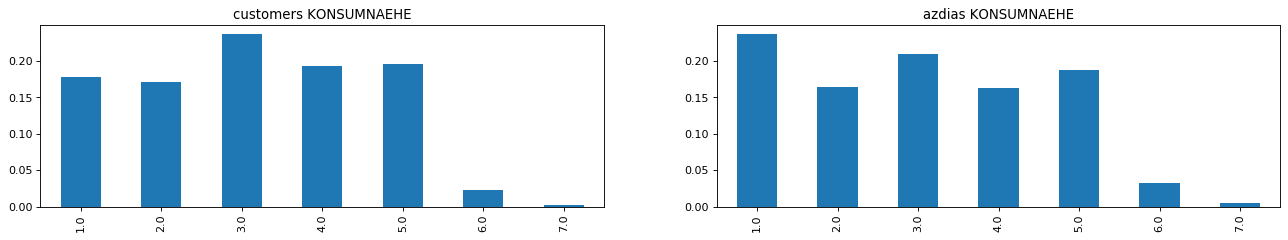

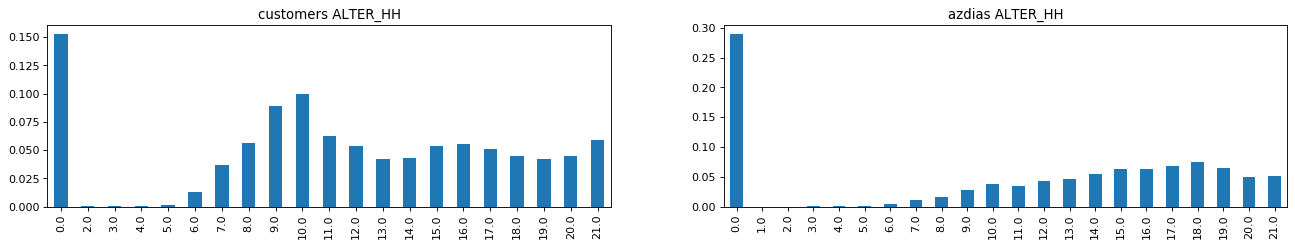

In [126]:
def plot_customers_azdias_value_counts(column_name, customers_df = customers, azdias_df= azdias):
    '''
    show one feature hist chart of customers and azdias side by side
    Args:
        column_name {string} a column, it exist in azdias and customers
    '''
    fig=plt.figure(figsize=(20, 3), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(1, 2, 1)
    customers_df[column_name].value_counts(normalize=True).sort_index().plot.bar(title='customers '+column_name)
    plt.subplot(1, 2, 2)
    azdias_df[column_name].value_counts(normalize=True).sort_index().plot.bar(title='azdias '+column_name)
    plt.show()

plot_customers_azdias_value_counts('KONSUMNAEHE')
plot_customers_azdias_value_counts('ALTER_HH')

In [96]:
def get_standard_scaled_df(dataframe):
    '''
    after fill of all nan value, use teh StandardScaler to standardize value 
    '''
    standard_df = pd.DataFrame(index=dataframe.index)
    scaler = StandardScaler()
    for col in dataframe.columns:
        data = dataframe[col].values.reshape(-1, 1) # only 2D data is allowed
        standard_df[col] = scaler.fit_transform(data)
    return standard_df

def get_min_max_scaled_df(dataframe):
    '''
    after fill of all nan value, use teh StandardScaler to standardize value 
    '''
    min_max_df = pd.DataFrame(index=dataframe.index)
    scaler = MinMaxScaler()
    for col in dataframe.columns:
        data = dataframe[col].values.reshape(-1, 1)
        min_max_df[col] = scaler.fit_transform(data)
    return min_max_df

In [97]:
%%time
azdias_media_fillna_std_df = get_standard_scaled_df(azdias_media_fillna_df)
azdias_media_fillna_max_min_df = get_min_max_scaled_df(azdias_media_fillna_df)
azdias_no_nan_std_df = get_standard_scaled_df(azdias_no_nan_df)
azdias_no_nan_max_min_df = get_min_max_scaled_df(azdias_no_nan_df)
azdias_numeric_std_df = get_standard_scaled_df(azdias_numeric_df)
azdias_numeric_max_min_df = get_min_max_scaled_df(azdias_numeric_df)
azdias_unknown_filled_std_df = get_standard_scaled_df(azdias_unknown_filled_df)
azdias_unknown_filled_max_min_df = get_min_max_scaled_df(azdias_unknown_filled_df)

CPU times: user 10.2 s, sys: 6.42 s, total: 16.6 s
Wall time: 17.9 s


In [98]:
%%time
customers_no_nan_std_df = get_standard_scaled_df(customers_no_nan_df)
customers_no_nan_max_min_df = get_min_max_scaled_df(customers_no_nan_df)
customers_unknown_filled_std_df = get_standard_scaled_df(customers_unknown_filled_df)
customers_unknown_filled_max_min_df = get_min_max_scaled_df(customers_unknown_filled_df)
customers_numeric_std_df = get_standard_scaled_df(customers_numeric_df)
customers_numeric_max_min_df = get_min_max_scaled_df(customers_numeric_df)
customers_media_fillna_std_df = get_standard_scaled_df(customers_media_fillna_df)
customers_media_fillna_max_min_df = get_min_max_scaled_df(customers_media_fillna_df)

CPU times: user 2.5 s, sys: 1.38 s, total: 3.87 s
Wall time: 4.02 s


In [99]:
azdias_std_df = pd.concat([azdias_media_fillna_std_df, azdias_no_nan_std_df, azdias_numeric_std_df, azdias_unknown_filled_std_df, azdias_categorigcal_df], axis=1)
azdias_std_df.head()

,GEBAEUDETYP_RASTER,GFK_URLAUBERTYP,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_LEBENSPHASE_FEIN,LP_STATUS_FEIN,PLZ8_BAUMAX,GREEN_AVANTGARDE,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,CAMEO_DEU_2015__8B,CAMEO_DEU_2015__8C,CAMEO_DEU_2015__8D,CAMEO_DEU_2015__9A,CAMEO_DEU_2015__9B,CAMEO_DEU_2015__9C,CAMEO_DEU_2015__9D,CAMEO_DEU_2015__9E,OST_WEST_KZ__O,OST_WEST_KZ__W
LNR,,,,,,,,,,,,,,,,,,,,,
910215,0.267123,0.752512,-0.011397,-0.404397,0.031552,-1.108411,-0.587083,-0.494701,-0.258584,-0.118316,...,0,0,0,0,0,0,0,0,0,0
910220,-0.872772,0.752512,-1.358570,0.360822,0.508299,-0.815711,-0.587083,-0.494701,0.212895,-0.118316,...,0,0,0,0,0,0,0,0,0,1
910225,0.267123,0.752512,1.335775,-0.659470,-0.921942,-0.523010,-0.587083,2.021423,0.145541,-0.118316,...,0,0,0,0,0,0,0,0,0,1
910226,0.267123,-1.806901,0.662189,-0.914542,-1.160315,1.233194,-0.587083,-0.494701,-0.460647,-0.118316,...,0,0,0,0,0,0,0,0,0,1
910241,1.407019,-0.669384,0.662189,1.636186,1.382335,-0.523010,0.128428,-0.494701,-0.325938,-0.118316,...,0,0,0,0,0,0,0,0,0,1


In [100]:
azdias_max_min_df = pd.concat([azdias_media_fillna_max_min_df, azdias_no_nan_max_min_df, azdias_numeric_max_min_df, azdias_unknown_filled_max_min_df, azdias_categorigcal_df], axis=1)
azdias_max_min_df.head()

,GEBAEUDETYP_RASTER,GFK_URLAUBERTYP,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_LEBENSPHASE_FEIN,LP_STATUS_FEIN,PLZ8_BAUMAX,GREEN_AVANTGARDE,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,CAMEO_DEU_2015__8B,CAMEO_DEU_2015__8C,CAMEO_DEU_2015__8D,CAMEO_DEU_2015__9A,CAMEO_DEU_2015__9B,CAMEO_DEU_2015__9C,CAMEO_DEU_2015__9D,CAMEO_DEU_2015__9E,OST_WEST_KZ__O,OST_WEST_KZ__W
LNR,,,,,,,,,,,,,,,,,,,,,
910215,0.75,0.818182,0.333333,0.181818,0.375,0.000000,0.00,0.0,0.006723,0.0,...,0,0,0,0,0,0,0,0,0,0
910220,0.50,0.818182,0.000000,0.454545,0.525,0.111111,0.00,0.0,0.018487,0.0,...,0,0,0,0,0,0,0,0,0,1
910225,0.75,0.818182,0.666667,0.090909,0.075,0.222222,0.00,1.0,0.016807,0.0,...,0,0,0,0,0,0,0,0,0,1
910226,0.75,0.000000,0.500000,0.000000,0.000,0.888889,0.00,0.0,0.001681,0.0,...,0,0,0,0,0,0,0,0,0,1
910241,1.00,0.363636,0.500000,0.909091,0.800,0.222222,0.25,0.0,0.005042,0.0,...,0,0,0,0,0,0,0,0,0,1


In [101]:
customers_std_df = pd.concat([customers_media_fillna_std_df, customers_no_nan_std_df, customers_numeric_std_df, customers_unknown_filled_std_df, customers_categorigcal_df], axis=1)
customers_std_df.head()

,GEBAEUDETYP_RASTER,GFK_URLAUBERTYP,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_LEBENSPHASE_FEIN,LP_STATUS_FEIN,PLZ8_BAUMAX,GREEN_AVANTGARDE,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,CAMEO_DEU_2015__8B,CAMEO_DEU_2015__8C,CAMEO_DEU_2015__8D,CAMEO_DEU_2015__9A,CAMEO_DEU_2015__9B,CAMEO_DEU_2015__9C,CAMEO_DEU_2015__9D,CAMEO_DEU_2015__9E,OST_WEST_KZ__O,OST_WEST_KZ__W
LNR,,,,,,,,,,,,,,,,,,,,,
9626,0.152119,-0.797955,1.517020,-0.496521,0.124612,1.078976,-0.388015,1.312832,-0.235979,-0.105218,...,0,0,0,0,0,0,0,0,0,1
9628,0.152119,-0.448042,1.517020,-0.496521,-0.144093,0.100123,-0.388015,-0.761712,-0.235979,-0.105218,...,0,0,0,0,0,0,0,0,0,0
143872,-1.242741,-1.147869,-1.673918,-0.720517,-0.345621,1.078976,1.535867,1.312832,-0.235979,-0.105218,...,0,0,0,0,0,0,0,0,0,1
143873,0.152119,1.301526,-0.876183,-0.944513,-1.218912,0.752692,-0.388015,-0.761712,-0.316443,-0.105218,...,0,0,0,0,0,0,0,0,0,1
143874,-1.242741,-1.497782,-1.673918,1.295446,0.863550,-1.857583,0.573926,-0.761712,0.246806,-0.105218,...,0,0,0,0,0,0,0,0,0,1


In [102]:
customers_max_min_df = pd.concat([customers_media_fillna_max_min_df, customers_no_nan_max_min_df, customers_numeric_max_min_df, customers_unknown_filled_max_min_df, customers_categorigcal_df], axis=1)
customers_max_min_df.head()

,GEBAEUDETYP_RASTER,GFK_URLAUBERTYP,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_LEBENSPHASE_FEIN,LP_STATUS_FEIN,PLZ8_BAUMAX,GREEN_AVANTGARDE,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,CAMEO_DEU_2015__8B,CAMEO_DEU_2015__8C,CAMEO_DEU_2015__8D,CAMEO_DEU_2015__9A,CAMEO_DEU_2015__9B,CAMEO_DEU_2015__9C,CAMEO_DEU_2015__9D,CAMEO_DEU_2015__9E,OST_WEST_KZ__O,OST_WEST_KZ__W
LNR,,,,,,,,,,,,,,,,,,,,,
9626,0.75,0.272727,0.666667,0.181818,0.500,1.000000,0.00,1.0,0.001912,0.0,...,0,0,0,0,0,0,0,0,0,1
9628,0.75,0.363636,0.666667,0.181818,0.400,0.666667,0.00,0.0,0.001912,0.0,...,0,0,0,0,0,0,0,0,0,0
143872,0.50,0.181818,0.000000,0.090909,0.325,1.000000,0.50,1.0,0.001912,0.0,...,0,0,0,0,0,0,0,0,0,1
143873,0.75,0.818182,0.166667,0.000000,0.000,0.888889,0.00,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
143874,0.50,0.090909,0.000000,0.909091,0.775,0.000000,0.25,0.0,0.013384,0.0,...,0,0,0,0,0,0,0,0,0,1


In [103]:
%%time
customers_std_df.to_pickle("customers_std_df.pkl")
print('Standard scaled customers data saved as customers_std_df.pkl')
customers_max_min_df.to_pickle("customers_max_min_df.pkl")
print('MinMax scaled customers data saved as customers_max_min_df.pkl')

azdias_std_df.to_pickle("azdias_std_df.pkl")
print('Standard scaled azdias data saved as azdias_std_df.pkl')
azdias_max_min_df.to_pickle("azdias_max_min_df.pkl")
print('MinMax scaled azdias data saved as azdias_max_min_df.pkl')

Standard scaled customers data saved as customers_std_df.pkl
MinMax scaled customers data saved as customers_max_min_df.pkl
Standard scaled azdias data saved as azdias_std_df.pkl
MinMax scaled azdias data saved as azdias_max_min_df.pkl
CPU times: user 5.13 s, sys: 18.8 s, total: 23.9 s
Wall time: 31.3 s


数据清洗归一化的工作完成，我们将数据的全部空值进行了填补。归一化我们选择了两种不同的方式，StandardScaler和MinMaxScaler。处理后的数据被保存在了本地，为了后面几分析做好了准备。

## 第1部分：顾客分类报告

项目报告的主体部分应该就是这部分。在这个部分，你应该使用非监督学习技术来刻画公司已有顾客和德国一般人群的人口统计数据的关系。这部分做完后，你应该能够描述一般人群中的哪一类人更可能是邮购公司的主要核心顾客，哪些人则很可能不是。

In [ ]:
def plot_attribute_value_proprtion(dataframe, column_name, i = 1):
    plt.subplot(1, 5, i)
    max_count = dataframe[column_name].value_counts().max()
    n_points = dataframe.shape[0]
    max_prop = max_count / n_points

    # generate tick mark locations and names
    tick_props = np.arange(0, max_prop, 0.1)
    tick_names = ['{:0.2f}'.format(v) for v in tick_props]

    sns.countplot(data=dataframe, x=column_name, hue='IS_CUSTOMER')
    plt.yticks(tick_props * n_points, tick_names)
    plt.ylabel(f'{column_name} procentage')

In [ ]:
print('we can load data from customers_max_min_df and azdias_max_min_df.pkl')
customers_df = pd.read_pickle('customers_std_df.pkl')
azdias_df = pd.read_pickle("azdias_std_df.pkl")

我们首先为两个数据集加上各自的标签IS_CUSTOMER。0值表示不是客户，数据来源于azdias，1表示客户，来源于customers。

In [ ]:
# add label 'IS_CUSTOMER' to data
azdias_df['IS_CUSTOMER'] = 0
customers_df['IS_CUSTOMER'] = 1
all_data_df = azdias_df.append(customers_df)
all_data_df.head()

In [ ]:
azdias['IS_CUSTOMER'] = 0
customers['IS_CUSTOMER'] = 1
all_df = azdias.append(customers)
all_df.head()

In [ ]:
# Import sklearn's cluster module
from sklearn import cluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

### 主成分分析PCA

首先通过累计可解释方差贡献率曲线，确定我们的n_components的数值。

In [ ]:
print(azdias_df.shape, customers_df.shape) 

In [ ]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    Args: n_components - int - the number of principal components to create
          data - the data you would like to transform

    Returns: pca - the pca object created after fitting the data
             X_pca - the transformed X matrix with new number of components
    '''
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

我们使用PCA，不给出具体的目标降维的数目，这样可以得到我们想要的cumulative explained variannce

In [ ]:
%%time
X = all_data_df.drop('IS_CUSTOMER', axis=1)
n_compnents = X.shape[1]
pca, X_pca = do_pca(n_compnents, X)

这里我们看到了，如果保留原有特征的95%信息。我们可以选择的降维到从原有的348降维到195。

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(1,348), np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(0,348, 20))
plt.hlines(y=0.95, xmin=0, xmax=195, zorder=5, color='red', linestyles='-')
plt.vlines(x=195, ymin=0, ymax=0.95, zorder=6, color='red', linestyles='-')
plt.xlabel('number of componts after dimension reduction')
plt.ylabel('cumulative explained variannce')

In [ ]:
azdias_X =azdias_df.drop('IS_CUSTOMER', axis=1)
pca_azdias, X_pca_azdias = do_pca(195, azdias_X)
customers_X =customers_df.drop('IS_CUSTOMER', axis=1)
pca_customers, X_pca_customers = do_pca(195, customers_X)

In [ ]:
azdias_dimensions = ['Dimension_{}'.format(i) for i in range(1,len(pca_azdias.components_)+1)]
azdias_components = pd.DataFrame(np.round(pca_azdias.components_, 4), columns = azdias_X.keys())
azdias_components.index = azdias_dimensions
azdias_components.head()

In [ ]:
customers_dimensions = ['Dimension_{}'.format(i) for i in range(1,len(pca_azdias.components_)+1)]
customers_components = pd.DataFrame(np.round(pca_customers.components_, 4), columns = customers_X.keys())
customers_components.index = customers_dimensions
customers_components.head()

In [ ]:
plt.figure(figsize=(80,8))
customers_components.loc['Dimension_1',:].sort_values(ascending=False).plot(kind = 'bar')

In [ ]:
fig, ax = plt.subplots(1, 2 ,figsize = (20,5))
customers_components.iloc[0,:].sort_values(ascending=False)[:5].plot(ax=ax[0], kind='bar')
customers_components.iloc[0,:].sort_values()[:5].plot(ax=ax[1], kind='bar')

In [ ]:
fig=plt.figure(figsize=(25, 3), dpi= 80)
plot_attribute_value_proprtion(all_df, 'FINANZ_UNAUFFAELLIGER', 1)
plot_attribute_value_proprtion(all_df, 'FINANZ_ANLEGER', 2)
plot_attribute_value_proprtion(all_df, 'FINANZ_SPARER', 3)
plot_attribute_value_proprtion(all_df, 'D19_KONSUMTYP', 4)
plot_attribute_value_proprtion(all_df, 'SEMIO_REL', 5)

经过PCA后，的每个dimension的每一行是一个权重的向量，一次我们可以看到这个向量中每个原始特征对应的在这个dimension中产生的正负作用。在Dimension_1中我们看到，前5位的是原始体征体现出客户的特征是

* FINANZ_UNAUFFAELLIGER 客户中有财务问题的相对低
* FINANZ_ANLEGER 多数客户拥有较高的理财投资
* FINANZ_SPARER 客户相对有高的存款积蓄
* D19_KONSUMTYP 消费结构，客户在美食消费占比高
* SEMIO_REL 客户人群分布在有一定宗教信仰的人中偏多


In [ ]:
fig, ax = plt.subplots(1, 2 ,figsize = (20,5))
customers_components.loc['Dimension_2',:].sort_values(ascending=False)[:5].plot(ax=ax[0], kind='bar')
customers_components.loc['Dimension_2',:].sort_values()[:5].plot(ax=ax[1], kind='bar')

In [ ]:
fig=plt.figure(figsize=(25, 3), dpi= 80)
plot_attribute_value_proprtion(all_df, 'D19_GESAMT_ANZ_24', 1)
plot_attribute_value_proprtion(all_df, 'D19_GESAMT_ANZ_12', 2)
plot_attribute_value_proprtion(all_df, 'ONLINE_AFFINITAET', 3)
plot_attribute_value_proprtion(all_df, 'D19_VERSAND_ANZ_24', 4)
plot_attribute_value_proprtion(all_df, 'D19_VERSAND_ANZ_12', 5)

再来看看Dimension_2，这里的一组特征D19_GESAMT_ANZ表现出客户人群中在最近的一到两年中相对都有过消费记录。ONLINE_AFFINITAET显示客户在网络上的活跃度也相对较高。

In [ ]:
fig, ax = plt.subplots(1, 2 ,figsize = (20,5))
azdias_components.loc['Dimension_1',:].sort_values(ascending=False)[:5].plot(ax=ax[0], kind='bar')
azdias_components.loc['Dimension_1',:].sort_values()[:5].plot(ax=ax[1], kind='bar')

In [ ]:
fig=plt.figure(figsize=(25, 3), dpi= 80)
plot_attribute_value_proprtion(all_df, 'HH_EINKOMMEN_SCORE', 1)
plot_attribute_value_proprtion(all_df, 'GEBAEUDETYP', 2)
plot_attribute_value_proprtion(all_df, 'D19_BILDUNG', 3)
plot_attribute_value_proprtion(all_df, 'KBA13_HALTER_20', 4)
plot_attribute_value_proprtion(all_df, 'GEBAEUDETYP', 5)

In [ ]:
fig=plt.figure(figsize=(25, 3), dpi= 80)
plot_attribute_value_proprtion(all_df, 'MOBI_REGIO', 1)
plot_attribute_value_proprtion(all_df, 'FINANZ_UNAUFFAELLIGER', 2)
plot_attribute_value_proprtion(all_df, 'FINANZ_ANLEGER', 3)
plot_attribute_value_proprtion(all_df, 'SEMIO_KRIT', 4)
plot_attribute_value_proprtion(all_df, 'SEMIO_REL', 5)

In [ ]:
fig=plt.figure(figsize=(25, 3), dpi= 80)
plot_attribute_value_proprtion(all_df, 'D19_GESAMT_ANZ_24', 1)
plot_attribute_value_proprtion(all_df, 'D19_GESAMT_ANZ_12', 2)
plot_attribute_value_proprtion(all_df, 'ONLINE_AFFINITAET', 3)
plot_attribute_value_proprtion(all_df, 'D19_VERSAND_ANZ_24', 4)
plot_attribute_value_proprtion(all_df, 'D19_VERSAND_ANZ_12', 5)

一般人群的前五指标：
        
    * MOBI_REGIO - moving patterns
    * FINANZ_UNAUFFAELLIGER - financial typology: unremarkable
    * FINANZ_ANLEGER - financial typology: investor
    * SEMIO_KRIT - affinity indicating in what way the person is critical minded
    * SEMIO_REL - affinity indicating in what way the person is religious
    
已有客户的前五指标：
     
    * D19_GESAMT_ANZ_24 - transaction activity TOTAL POOL in the last 24 months 
    * D19_GESAMT_ANZ_12 - transaction activity TOTAL POOL in the last 12 months 
    * ONLINE_AFFINITAET - online affinity
    * D19_VERSAND_ANZ_24 - transaction activity MAIL-ORDER in the last 24 months
    * D19_VERSAND_ANZ_12 -transaction activity MAIL-ORDER in the last 12 months

### KMeans Clustering

In [ ]:
X = all_data_df.drop('IS_CUSTOMER', axis=1)
X.shape
true_labels = all_data_df['IS_CUSTOMER'].values

In [ ]:
score_list = []
print('new_attribute,score,score_diff')
for i in range(1,347):
    cols = X.columns[:i]
    
    kmeans = KMeans(2)
    cluster = kmeans.fit(X[cols])
    predict_labels = kmeans.labels_
    
    current_score = adjusted_rand_score(true_labels, predict_labels)
    score_list.append(current_score)
    if i > 1:
        score_diff = np.abs(score_list[i-2] - current_score)
    else:
        score_diff = 0
    print(cols.values[i-1], ',', current_score, ',', score_diff)


In [ ]:
%%time
# X = all_data_df.drop('IS_CUSTOMER', axis=1)
distortions = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, 
                    init='k-means++', 
                    n_init=10, 
                    max_iter=300, 
                    random_state=0)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

In [ ]:
%%time
#elbow method
n_clusters = np.arange(1,25)
scores = [MiniBatchKMeans(i).fit(X_pca_azdias).score(X_pca_azdias) for i in n_clusters]
plt.figure(figsize=(15,8))
plt.plot(n_clusters, np.abs(scores), linestyle='-', marker='o')
plt.xlabel('number of clustering')
plt.ylabel('score')
plt.title('K-Means score and K number')

In [ ]:
%%time
# we use K=10 to get clusters for PCA processed azdias and customers
kmeans = KMeans(n_clusters=10)

azdias_predict = kmeans.fit_predict(X_pca_azdias)
customers_predict = kmeans.fit_predict(X_pca_customers)

In [ ]:
%%time
# we use K=10 to get clusters for PCA processed azdias and customers
minikmeans = MiniBatchKMeans(n_clusters=10)

azdias_mbk_predict = minikmeans.fit_predict(X_pca_azdias)
customers_mbk_predict = minikmeans.fit_predict(X_pca_customers)

同样使用K=10，我们发现MiniBatchKMeans相比Kmeans有很大的有优势。对于后面再分类结果上，我们还可以进一步加以研究。

In [ ]:
azdias_clusters_df = pd.DataFrame({'cluster_id':  np.unique(azdias_mbk_predict),
                                   'count':  np.bincount(azdias_mbk_predict), 
                                   'percent': (np.bincount(azdias_mbk_predict)/azdias_mbk_predict.shape[0]*100).round(2)})
azdias_clusters_df['type']='azdias'

customers_clusters_df = pd.DataFrame({'cluster_id':  np.unique(customers_mbk_predict),
                                      'count':  np.bincount(customers_mbk_predict), 
                                      'percent': (np.bincount(customers_mbk_predict)/customers_mbk_predict.shape[0]*100).round(2)})
customers_clusters_df['type'] = 'customers'

In [ ]:
(azdias_clusters_df['percent'] - customers_clusters_df['percent']).sort_values()

In [ ]:
clusters_df = customers_clusters_df.append(azdias_clusters_df)
plt.figure(figsize=(15,8))
ax=sns.catplot(data= clusters_df, x = 'cluster_id',y = 'percent', hue = 'type', kind='bar', sharey=True, height=5, aspect=2)
ax.set(title=f'Global Cluster vs. Customer Cluster')

通过上面的图形，在cluster 1, 2和9中我们看到客户比例高于普通人群。我们查看以下对这个簇分类是参数最大作用的PCA主成分，发现是Dimension_1和Dimension_2有最高的正向作用。而Dimension_6和Dimension_7有负面的影响。

In [ ]:
centro_df = pd.DataFrame(minikmeans.cluster_centers_[2], columns=['pca_component_weights'])
centro_df.reindex(centro_df.abs().sort_values('pca_component_weights',ascending=False).index).head()

In [ ]:
def plot_component_attribute_weight(pca_compoent_df, component_index, features_list, n_weights=10):
    componet_selected_row = pca_compoent_df.iloc[:,component_index]
    componet_row = np.squeeze(componet_selected_row.values)

    comps = pd.DataFrame(list(zip(componet_row, features_list)), columns=['variances', 'features'])
    comps['abs_variances'] = comps['variances'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_variances', ascending=False).head(n_weights)

    ax = plt.subplots(figsize=(20,5))
    ax = sns.barplot(data=sorted_weight_data,  x="variances", y="features")
    ax.set_title(f'PCA Component {str(component_index)} and original Features Variances')
    # plt.xticks(rotation=90)
    plt.show()

In [ ]:
plot_component_attribute_weight(customers_components, 0, customers.columns.values)

# 第2部分：监督学习模型

你现在应该已经发现哪部分人更可能成为邮购公司的顾客了，是时候搭建一个预测模型了。"MAILOUT"数据文件的的每一行表示一个邮购活动的潜在顾客。理想情况下我们应该能够使用每个人的人口统计数据来决定是否该把他作为该活动的营销对象。

"MAILOUT" 数据被分成了两个大致相等的部分，每部分大概有 43 000 行数据。在这部分，你可以用"TRAIN"部分来检验你的模型，该数据集包括一列"RESPONSE"，该列表示该对象是否参加了该公司的邮购活动。在下一部分，你需要在"TEST"数据集上做出预测，该数据集中"RESPONSE" 列也被保留了。

In [ ]:
# only runable on udacity workspace
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [163]:
mailout_train = pd.read_csv(drive_path+'Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.set_index('LNR', inplace=True)
mailout_train.head()

/Users/qiangli/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,0.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,NaN,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,0.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,0.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [164]:
# load meta date like preprocess of data
attribute_info_df, attribute_values_df = load_xlsx_files()
numeric_attributes = attribute_values_df[attribute_values_df['Value'] == '…']
column_unknow_values = get_unknown_values(attribute_values_df)
attributes_without_meta = get_attribute_without_value_info()

In [165]:
# get label as y 
mailout_train_y = mailout_train['RESPONSE']
mailout_train = mailout_train.drop(['RESPONSE'], axis=1, errors='ignore')

In [135]:
def arvator_pipline(mailout_df, numeric_attributes, column_unknow_values, attributes_without_meta):
    # fill cameo_columns
    cameo_columns_fillna(mailout_df)
    mailout_categorigcal_df = one_hot_encode_categorie_columns(mailout_df)
    processed_attributes = ['CAMEO_DEU_2015', 'OST_WEST_KZ']
    mailout_unprocessed_df = mailout_df.drop(processed_attributes, axis=1, errors='ignore')
    # fill numeric columns
    mailout_numeric_df = numeric_fillna_median(mailout_df, numeric_attributes)
    processed_attributes = processed_attributes + list(mailout_numeric_df.columns)
    # fill columns with unknown values
    mailout_unknown_filled_df = process_unknown_and_nan(mailout_df, column_unknow_values, processed_attributes)
    processed_attributes = processed_attributes + list(mailout_unknown_filled_df.columns)
    # drop columns without any meta info
    mailout_df = drop_no_info_columns(mailout_df, attributes_without_meta)
    mailout_unprocessed_df = mailout_df.drop(processed_attributes, axis=1, errors='ignore')
    processed_attributes = processed_attributes + list(attributes_without_meta)
    # drop column with ending '_GROB'
    drop_grob_columns(mailout_unprocessed_df)
    grob_columns = get_columns_endswith_grob(mailout_df)
    processed_attributes = processed_attributes + grob_columns
    mailout_unprocessed_df = mailout_df.drop(processed_attributes, axis=1, errors='ignore')

    mailout_media_fillna_df = fill_nan_with_median(mailout_df[get_columns_has_nan(mailout_unprocessed_df)])
    processed_attributes = processed_attributes + list(mailout_media_fillna_df.columns)
    mailout_unprocessed_df = mailout_df.drop(processed_attributes, axis=1, errors='ignore')

    mailout_no_nan_df = mailout_unprocessed_df

    mailout_processed_df = pd.concat([mailout_media_fillna_df, 
                                        mailout_unknown_filled_df, 
                                        mailout_numeric_df, 
                                        mailout_categorigcal_df, 
                                        mailout_no_nan_df], axis=1)
    
    mailout_df_X = get_standard_scaled_df(mailout_processed_df)
    return mailout_df_X

In [166]:
mailout_train_X = arvator_pipline(mailout_train, 
                                  numeric_attributes, 
                                  column_unknow_values, 
                                  attributes_without_meta)

after cleanup column CAMEO_DEU_2015 has values: ['5D' '5B' '2D' '7B' '4C' '5C' '-1' '3D' '5A' '2C' '4A' '6B' '1A' '8D'
 '4B' '7A' '4E' '3A' '7C' '9D' '8A' '5E' '8B' '3C' '6E' '4D' '2B' '3B'
 '7E' '2A' '6C' '1C' '6D' '7D' '1D' '8C' '9A' '9B' '9C' '9E' '6F' '1E'
 '6A' '5F' '1B']

after cleanup column CAMEO_DEUG_2015 has values: [ 5  2  7  4 -1  3  6  1  8  9]

after cleanup column CAMEO_INTL_2015 has values: [34 32 14 41 24 33 -1 25 31 22 43 13 55 23 54 51 45 12 44 35 15 52]

before drop columns count:365, and after drop columns count:304
delete ['LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB'] from dataframe


In [168]:
mailout_train_X.shape
print(mailout_test_X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 347 entries, GEBAEUDETYP_RASTER to GREEN_AVANTGARDE
dtypes: float64(347)
memory usage: 113.4 MB
None


In [141]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve

In [240]:
X_train, X_test, y_train, y_test = train_test_split(mailout_train_X, mailout_train_y, test_size=0.2, random_state=500)

In [249]:
lr = LogisticRegression(penalty='l2', solver='saga', C=0.5, max_iter=100, class_weight={0:0.9, 1:0.1})
lr = lr.fit(X_train, y_train)
score = lr.score(X_test, y_test)
print(f'score = {score}')

score = 0.9876643779820784


/Users/qiangli/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


虽然score很高，但是我们发现要想正确评价logisticRegression是不对的。我们应该使用的是ROC曲线来看我们模型效果。我们希望通过找到最大的AUC面积才是最终衡量模型的好坏的标准。

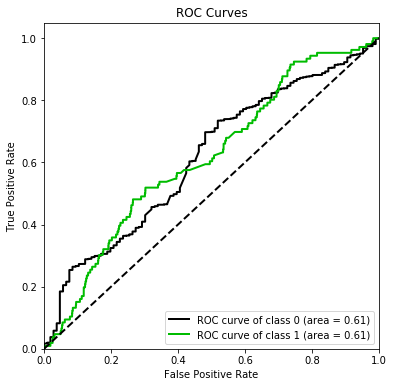

In [248]:
import scikitplot as skplt
vali_proba_df = pd.DataFrame(lr.predict_proba(X_test))
skplt.metrics.plot_roc(y_test, vali_proba_df,
                      plot_micro=False,
                      plot_macro=False,
                      figsize=(6,6))

score = 0.9876643779820784


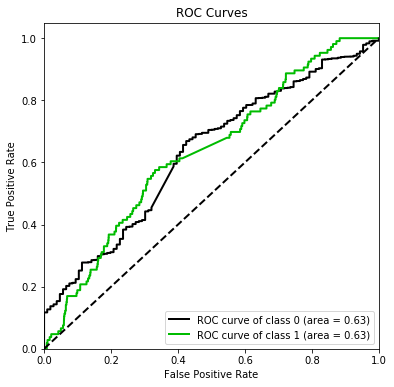

In [250]:
lr = LogisticRegression(penalty='l1', solver='liblinear', C=0.5, max_iter=100, class_weight={0:0.91, 1:0.09})
lr = lr.fit(X_train, y_train)
score = lr.score(X_test, y_test)
print(f'score = {score}')
import scikitplot as skplt
vali_proba_df = pd.DataFrame(lr.predict_proba(X_test))
skplt.metrics.plot_roc(y_test, vali_proba_df,
                      plot_micro=False,
                      plot_macro=False,
                      figsize=(6,6))

In [143]:
lr = LogisticRegression(penalty='l1', solver='liblinear', C=1, max_iter=100)
train_size, train_acc, test_acc = learning_curve(lr, mailout_train_X, mailout_train_y, cv=10)

In [ ]:
score_list = []
for i in range(0, 200, 10):
    lr = LogisticRegression(penalty='l2', solver='liblinear', C=1, max_iter=100)
    score = cross_val_score(lr, mailout_train_X, mailout_train_y, cv=10).mean()
    score_list.append(score)
    
print(max(score_list), (score_list.index(max(score_list))*10)+1)

plt.figure(figsize=[20, 5])
plt.plot(range(1, 201, 10), score_list, marker='o')

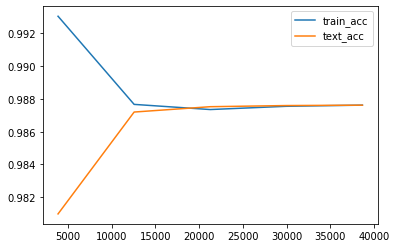

In [147]:
lr = LogisticRegression(penalty='l2', solver='liblinear', C=1, max_iter=100)
train_size, train_acc, test_acc = learning_curve(lr, mailout_train_X, mailout_train_y, cv=10)
# plot learning_curve
plt.figure(figsize=[20, 5])
plt.plot(train_size, train_acc.mean(axis=1), label='train_acc')
plt.plot(train_size, test_acc.mean(axis=1), label='text_acc')
plt.legend()
plt.show()

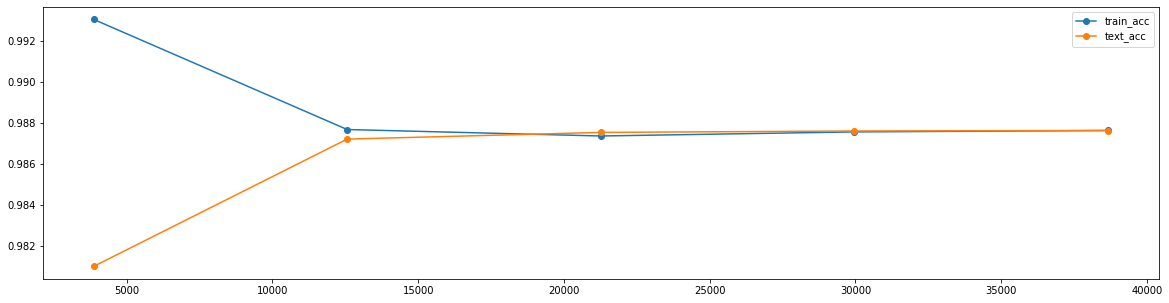

In [150]:
# plot learning_curve
plt.figure(figsize=[20, 5])
plt.plot(train_size, train_acc.mean(axis=1), label='train_acc', marker='o' )
plt.plot(train_size, test_acc.mean(axis=1), label='text_acc', marker='o')
plt.legend()
plt.show()

In [ ]:
## Wall time: 17min 55s
%%time
rfr = RandomForestRegressor(n_estimators=50, random_state=90)
scroe_pre = cross_val_score(rfr, mailout_train_X, mailout_train_y, cv=10).mean() # 交叉验证分数 cross_val_score
print(f'RandomForestRegressor score={scroe_pre}')

In [ ]:
%%time
#### TIME WARNING ######
score_list = []
for i in range(0, 200, 10):
    rfc = RandomForestRegressor(n_estimators=i+1, random_state=90)
    score = cross_val_score(rfc, mailout_train_X, mailout_train_y, cv=10).mean()
    score_list.append(score)
    
print(max(score_list), (score_list.index(max(score_list))*10)+1)

plt.figure(figsize=[20, 5])
plt.plot(range(1, 201, 10), score_list)

In [ ]:
# turning max_depth
param_grid = {'max_depth': np.arange(1, 100, 1)}
rfr = RandomForestRegressor(n_estimators=51, 
                            n_job=-1, 
                            random_state=90) # n_estimators fron last step
GS = GridSearchCV(rfr, param_grid, cv=10)
GS.fit(mailout_train_X, mailout_train_y)

In [ ]:
GS.best_params_ # 显示最佳参数

In [ ]:
GS.best_score_ # 显示最佳参数对应的分数

In [ ]:
%%time
### last run Wall time: 1h 57min 16s ####
superpa = []
for i in range(50):
    regressor = RandomForestRegressor(n_estimators=i+1, n_jobs=-1)
    regressor_s = cross_val_score(regressor, mailout_train_X, mailout_train_y, cv=10, scoring='neg_mean_squared_error').mean()
    superpa.append(regressor_s)

print(max(superpa), superpa.index(max(superpa)))
plt.figure(figsize = [20, 5])
plt.plot(range(1, 51), superpa)
plt.show()

In [ ]:
%%time
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
# 交叉验证 cross_val_score
cross_val_score(regressor, mailout_train_X, mailout_train_y, cv=10, scoring='neg_mean_squared_error')

## 第3部分：Kaggle比赛

你已经搭建了一个用于预测人们有多大程度上会回应邮购活动的模型，是时候到Kaggle上检验一下这个模型了。如果你点击这个 [链接](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140)，你会进入到比赛界面（如果你已经有一个Kaggle账户的话）如果你表现突出的话，你将有机会收到Arvato或Bertelsmann的人力资源管理的经理的面试邀约！

你比赛用提交的文件格式为CSV，该文件含2列。第一列是"LNR"，是"TEST"部分每个顾客的ID。第二列是"RESPONSE"表示此人有多大程度上会参加该活动，可以是某种度量，不一定是概率。你应该在第2部分已经发现了，该数据集存在一个巨大的输出类不平衡的问题，也就是说大部分人都不会参加该邮购活动。因此，预测目标人群的分类并使用准确率来衡量不是一个合适的性能评估方法。相反地，该项竞赛使用AUC衡量模型的性能。"RESPONSE"列的绝对值并不重要：仅仅表示高的取值可能吸引到更多的实际参与者，即ROC曲线的前端曲线比较平缓。

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [172]:
mailout_test = pd.read_csv(drive_path+'/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test.set_index('LNR', inplace=True)
mailout_test.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,0.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,0.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,0.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [174]:
mailout_test_X = arvator_pipline(mailout_test, 
                             numeric_attributes, 
                             column_unknow_values, 
                             attributes_without_meta)
mailout_test_X.head()

after cleanup column CAMEO_DEU_2015 has values: ['2B' '5A' '7A' '9D' '4E' '6B' '2D' '1D' '7E' '4C' '-1' '1C' '4A' '5F'
 '6D' '3C' '9B' '6C' '8B' '3D' '5D' '1A' '3A' '7B' '2C' '8A' '6F' '2A'
 '5B' '6E' '5C' '8D' '4D' '8C' '9E' '7C' '9A' '6A' '9C' '1B' '3B' '7D'
 '1E' '4B' '5E']

after cleanup column CAMEO_DEUG_2015 has values: [ 2  5  7  9  4  6  1 -1  3  8]

after cleanup column CAMEO_INTL_2015 has values: [13 31 41 51 25 43 14 15 45 24 -1 22 35 44 34 23 12 32 33 55 54 52]

before drop columns count:365, and after drop columns count:304
delete ['LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB'] from dataframe


,GEBAEUDETYP_RASTER,GFK_URLAUBERTYP,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_LEBENSPHASE_FEIN,LP_STATUS_FEIN,PLZ8_BAUMAX,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,...,CAMEO_DEU_2015__8C,CAMEO_DEU_2015__8D,CAMEO_DEU_2015__9A,CAMEO_DEU_2015__9B,CAMEO_DEU_2015__9C,CAMEO_DEU_2015__9D,CAMEO_DEU_2015__9E,OST_WEST_KZ__O,OST_WEST_KZ__W,GREEN_AVANTGARDE
LNR,,,,,,,,,,,,,,,,,,,,,
1754,-1.057894,1.166149,0.627075,-0.483199,0.161537,1.202023,-0.500674,1.033789,0.728696,-0.236176,...,-0.178527,-0.164834,-0.100583,-0.106906,-0.100583,-0.125292,-0.097458,-0.495122,0.774505,1.600254
1770,0.189395,1.166149,-0.818110,-0.711663,-0.838129,-1.452029,-0.500674,-1.086712,0.728696,-1.274215,...,-0.178527,-0.164834,-0.100583,-0.106906,-0.100583,-0.125292,-0.097458,-0.495122,0.774505,-0.624901
1465,0.189395,-0.493617,-1.540703,1.344519,1.589631,1.202023,-0.500674,1.033789,0.728696,1.098445,...,-0.178527,-0.164834,-0.100583,-0.106906,-0.100583,-0.125292,-0.097458,-0.495122,0.774505,1.600254
1470,0.189395,-0.161664,0.627075,-0.940128,-1.266557,-0.862239,-0.500674,-1.086712,0.728696,-1.274215,...,-0.178527,-0.164834,-0.100583,-0.106906,-0.100583,-0.125292,-0.097458,2.019706,-1.291147,-0.624901
1478,1.436685,1.166149,2.072260,1.572984,1.375417,0.907128,-0.500674,0.326956,0.728696,1.839902,...,-0.178527,-0.164834,-0.100583,-0.106906,-0.100583,-0.125292,-0.097458,-0.495122,0.774505,-0.624901


In [255]:
predict_proba = lr.predict_proba(mailout_test_X)
predict_proba[:, 1]


array([0.00182224, 0.00175874, 0.00061523, ..., 0.00147485, 0.00104388,
       0.00074219])

In [263]:
predicat_result = pd.DataFrame(list(zip(mailout_test.index, predict_proba[:, 1])), columns=['LNR', 'RESPONSE'])
predicat_result

,LNR,RESPONSE
0,1754,0.001822
1,1770,0.001759
2,1465,0.000615
3,1470,0.000524
4,1478,0.000866
...,...,...
42828,67615,0.001314
42829,67938,0.002568
42830,67942,0.001475
42831,67949,0.001044


In [265]:
predicat_result.to_csv('result_Kaggle.csv', index=False)